In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix
from skopt import BayesSearchCV

# Global parameters and constants

In [2]:
label_map = {
    0: 'background',
    1: 'person',
    2: 'car',
    3: 'dog',
    4: 'cow'
}

label_map_inverse = {
    'background': 0,
    'person': 1,
    'car': 2,
    'dog': 3,
    'cow': 4
}

label_map_pt = {
    1: 'pessoa',
    2: 'carro',
    3: 'cachorro',
    4: 'vaca'
}

# Functions

In [3]:
def load_csi_matrices(
        classes: list[str],
        train: bool = True,
        dtype: np.float16 | np.float32 = np.float32,
        normalization: bool = False,
        random_state: int = 42

) -> tuple[np.array, pd.Series]:
    """
        :param classes: options: 'background', 'car', 'dog', 'person', 'cow'
        :param train: whether to load train ou test data
        :param dtype: float dtype
        :param normalization: If true, each matrix is normalized by its absolute mean
    """
    file_path_label = 'TRAIN' if train else 'TEST'
    desired_classes = [label_map_inverse[desired_class] for desired_class in classes]
    classes_to_exclude = list(filter(lambda x: x not in desired_classes, label_map.keys()))
    data = pd.read_parquet(f'./data/{file_path_label}_person3_car2_dog3_cow2_noise3.parquet').sample(frac=1, random_state=random_state)
    data = data[~data['label'].isin(classes_to_exclude)]
    data_matrices = data.iloc[:, 1:].values.reshape(-1, 500, 52).transpose(0, 2, 1).astype(dtype)

    if normalization:
        data_matrices /= abs(np.expand_dims(data_matrices.mean(axis=(1,2)), axis=[1, 2]))

    return data_matrices, data['label']

def extract_features(csi_matrices: np.array) -> np.array:
    carrier_means = csi_matrices.mean(axis=2)
    carrier_stds = csi_matrices.std(axis=2)
    features = np.concatenate([carrier_means, carrier_stds], axis=1)
    return features

def train_and_evaluate_model(model, x_test, y_test, x_train, y_train):
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    acc_score = accuracy_score(y_test, preds)
    conf_matrix = confusion_matrix(y_test, preds)

    return model, acc_score, conf_matrix


def run_permutation_importance(model, x_test, y_test, n_repeats=10, random_state=1):
    result = permutation_importance(model, x_test, y_test, n_repeats=n_repeats, random_state=random_state)
    importances = pd.DataFrame(data={'mean': result.importances_mean, 'std': result.importances_std})
    importances = importances.sort_values('mean', ascending=False)

    return importances

In [4]:
def plot_some_matrices(n=0):
    examples = pd.read_parquet('./data/TRAIN_person3_car2_dog3_cow2_noise3.parquet')

    fig, ax = plt.subplots(4, 1, figsize=(15, 8), dpi=200)
    for i, (label, name) in enumerate(label_map_pt.items()):
        filtered_df = examples[examples.label == label]
        example = filtered_df.iloc[n, 1:].values.reshape(500, 52).transpose(1, 0)
        im = ax[i].imshow(example, vmin=-90, vmax=-75, cmap='plasma')
        ax[i].set_title(f'Exemplo de {name} - Amplitude das medições CSI')
        ax[i].set_xlabel('Vetor CSI')
        ax[i].set_ylabel('Subportadora')
        plt.colorbar(im, ax=ax[i], label='dBm')


    plt.tight_layout()
    plt.show()

def plot_some_features(n=0):
    examples = pd.read_parquet('./data/TRAIN_person3_car2_dog3_cow2_noise3.parquet')

    fig, ax = plt.subplots(4, 2, figsize=(16, 16), dpi=200)
    for i, (label, name) in enumerate(label_map_pt.items()):
        filtered_df = examples[examples.label == label]
        example = filtered_df.iloc[n, 1:].values.reshape(500, 52).transpose(1, 0)
        example /= example.mean()
        example_carrier_means = example.mean(axis=1)
        example_carrier_stds = example.std(axis=1)

        im = ax[i][0].imshow(np.expand_dims(example_carrier_means, axis=0), aspect=10, cmap='plasma')
        ax[i][0].set_title(f'Médias normalizadas ({name})')
        ax[i][0].set_xlabel('Índice da subportadora')
        ax[i][0].set_yticks([])
        plt.colorbar(im, ax=ax[i][0], label='Intensidade (Adimensional)')

        im = ax[i][1].imshow(np.expand_dims(example_carrier_stds, axis=0), aspect=10, cmap='plasma')
        ax[i][1].set_title(f'Desvios padrões normalizados ({name})')
        ax[i][1].set_xlabel('Índice da subportadora')
        ax[i][1].get_yaxis().set_visible(False)
        plt.colorbar(im, ax=ax[i][1], label='Intensidade (Adimensional)')


plt.show()

# Training

In [5]:
train_matrices, train_labels = load_csi_matrices(
                                    classes=['person', 'car', 'dog', 'cow'],
                                    train=True,
                                    normalization=True
                                )
train_features = extract_features(train_matrices)

test_matrices, test_labels = load_csi_matrices(
                                    classes=['person', 'car', 'dog', 'cow'],
                                    train=False,
                                    normalization=True
                                )
test_features = extract_features(test_matrices)

model, acc_score, conf_matrix = train_and_evaluate_model(
    model=KNeighborsClassifier(n_neighbors=30),
    x_train=train_features,
    y_train=train_labels,
    x_test=test_features,
    y_test=test_labels
)

print(acc_score) 
print(conf_matrix)

0.9700996677740864
[[97  0  1  0]
 [ 0 63  0  0]
 [ 8  0 76  0]
 [ 0  0  0 56]]


# Visualizations

In [5]:
scores_16 = []
scores_32 = []
ks = range(1, 50, 2)

train_matrices_16, train_labels_16 = load_csi_matrices(
                                    classes=['person', 'car', 'dog', 'cow'],
                                    train=True,
                                    normalization=True,
                                    dtype=np.float16
                                )
train_features_16 = extract_features(train_matrices_16)

test_matrices_16, test_labels_16 = load_csi_matrices(
                                    classes=['person', 'car', 'dog', 'cow'],
                                    train=False,
                                    normalization=True,
                                    dtype=np.float16
                                )
test_features_16 = extract_features(test_matrices_16)

for k in ks:
    _, acc_score_16, _ = train_and_evaluate_model(
        model=KNeighborsClassifier(n_neighbors=k),
        x_train=train_features_16,
        y_train=train_labels_16,
        x_test=test_features_16,
        y_test=test_labels_16
    )
    scores_16.append(acc_score_16)

    _, acc_score_32, _ = train_and_evaluate_model(
        model=KNeighborsClassifier(n_neighbors=k),
        x_train=train_features,
        y_train=train_labels,
        x_test=test_features,
        y_test=test_labels
    )
    scores_32.append(acc_score_32)



fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=200)

ax.scatter(ks, scores_32, s=80, label='float32', color='blue')
ax.scatter(ks, scores_16, s=80, label='float16', color='red')

plt.xticks(ks)
plt.xlabel('K')
plt.ylabel('Acurácia (0 a 1)')
plt.title('Performance do KNN')
plt.grid()
plt.legend()
plt.show()


NameError: name 'train_features' is not defined

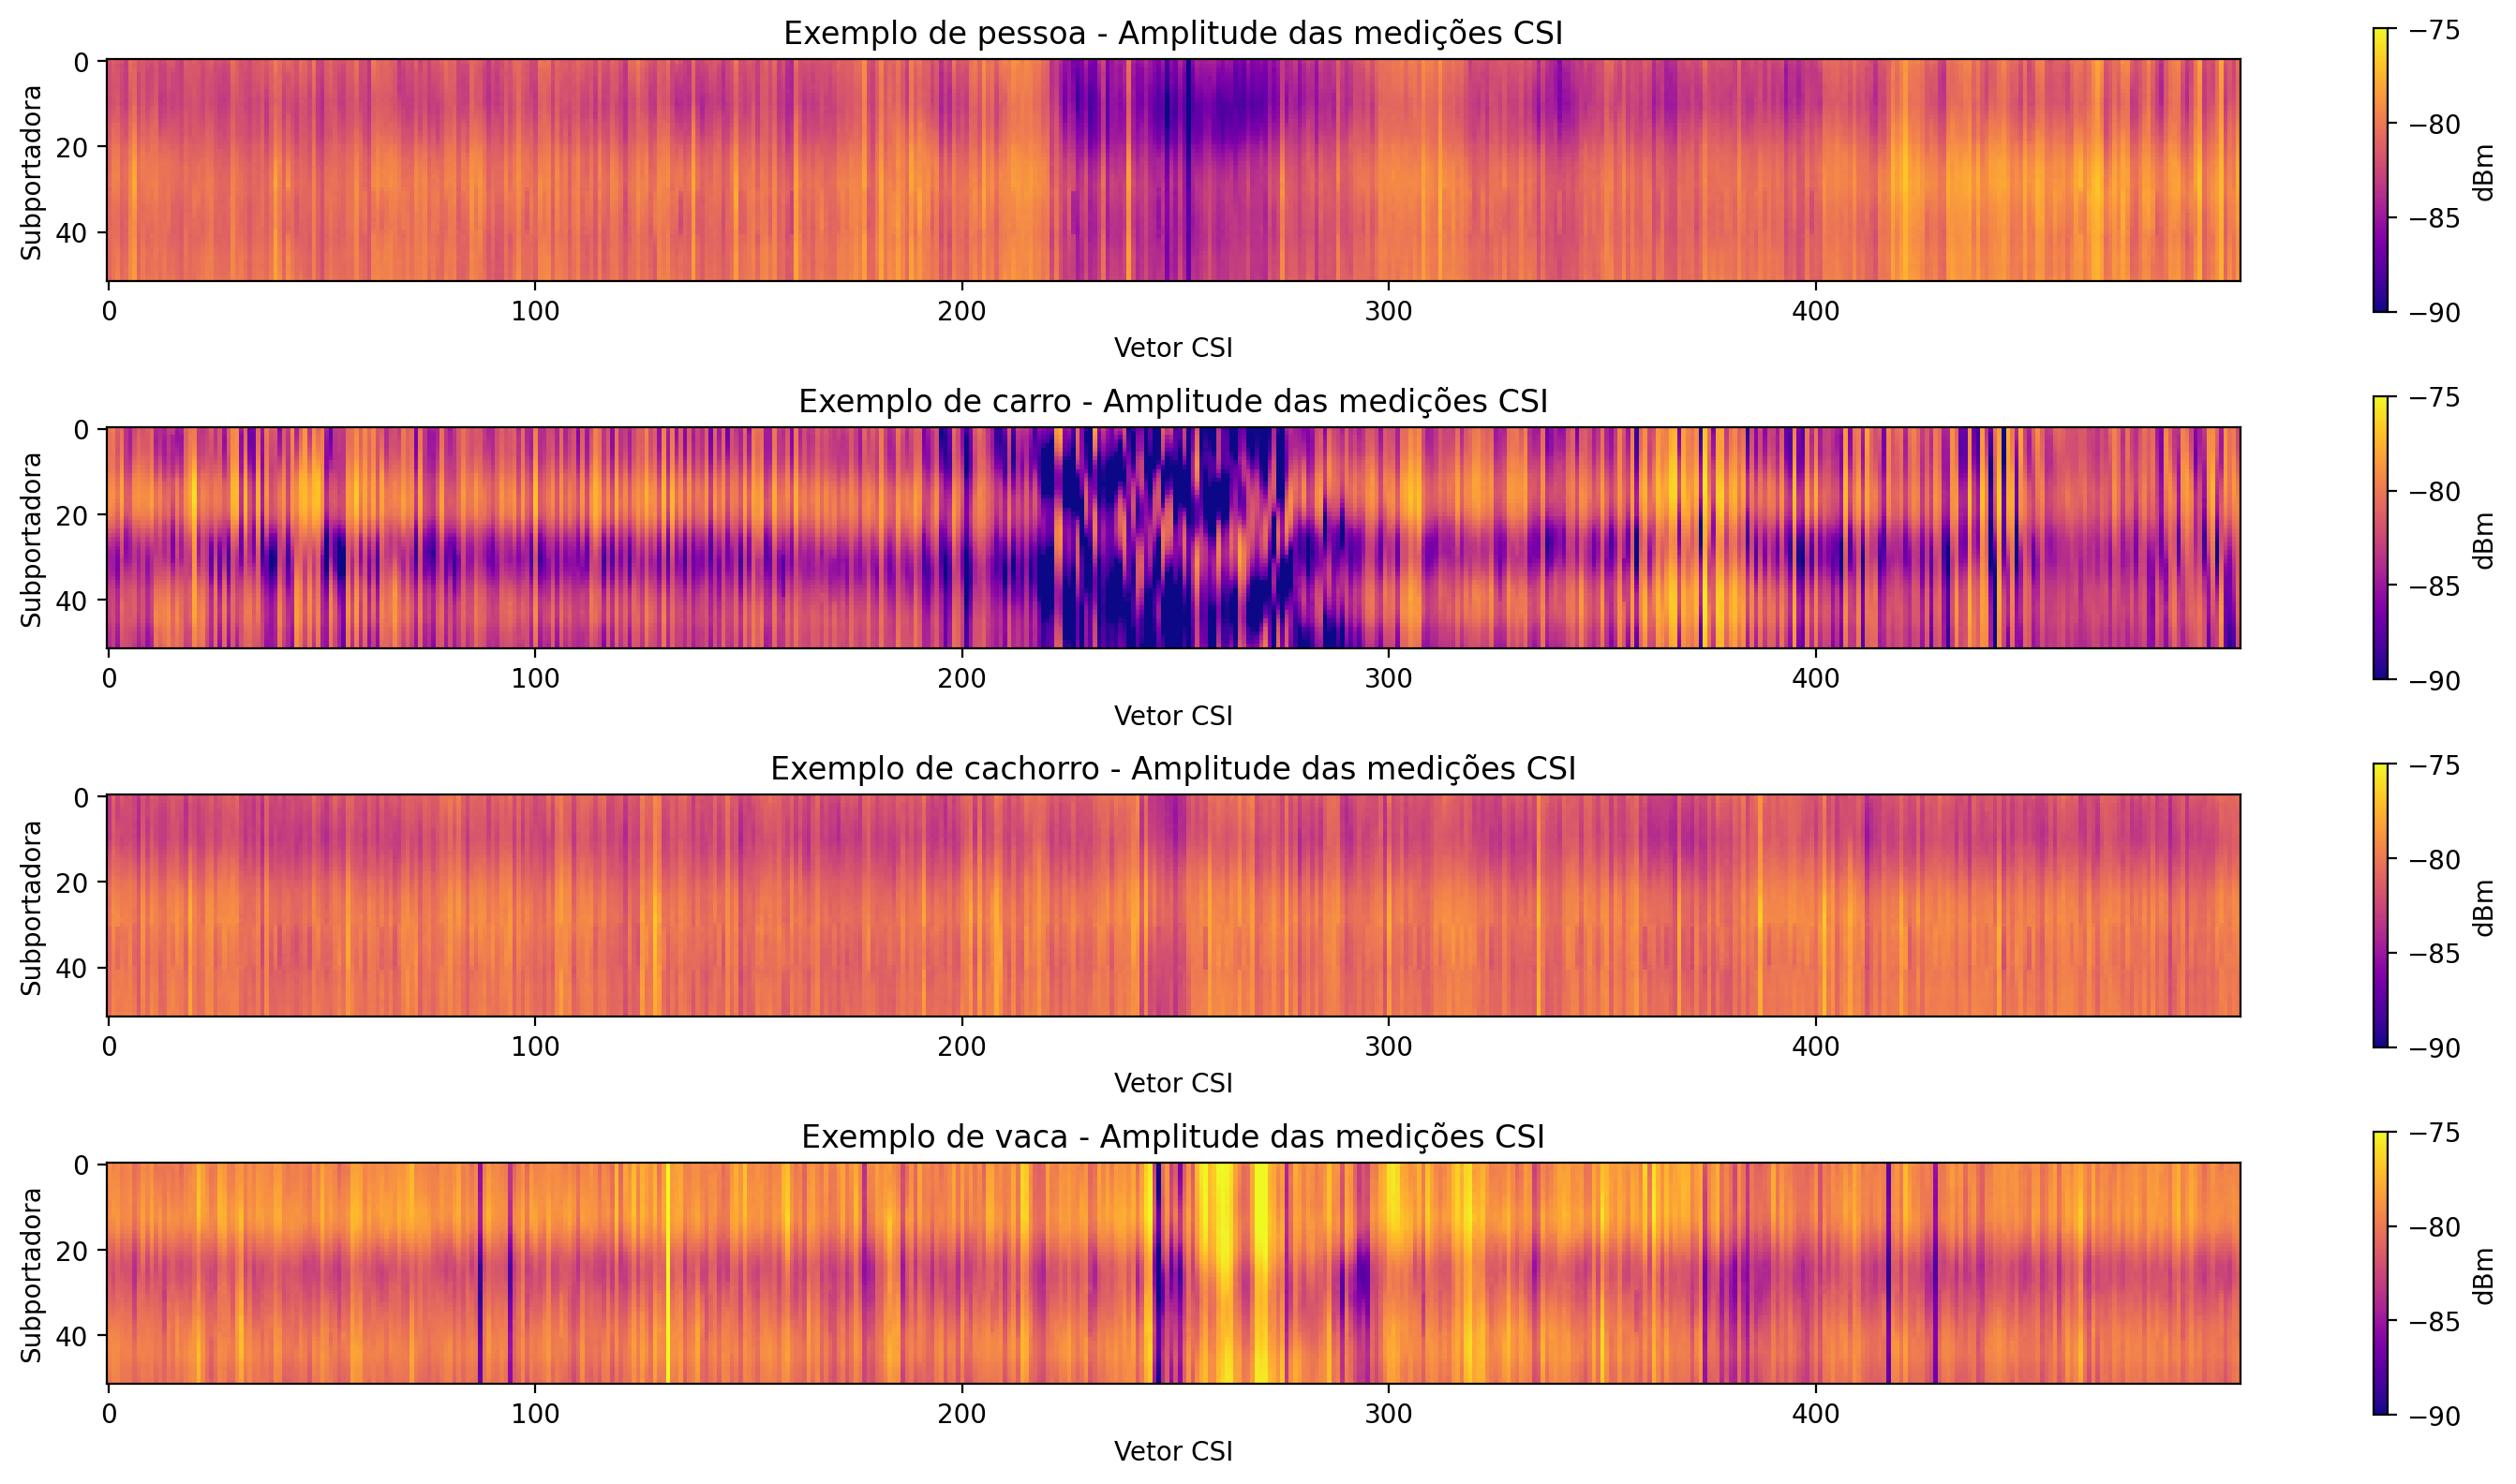

In [7]:
plot_some_matrices(n=10)

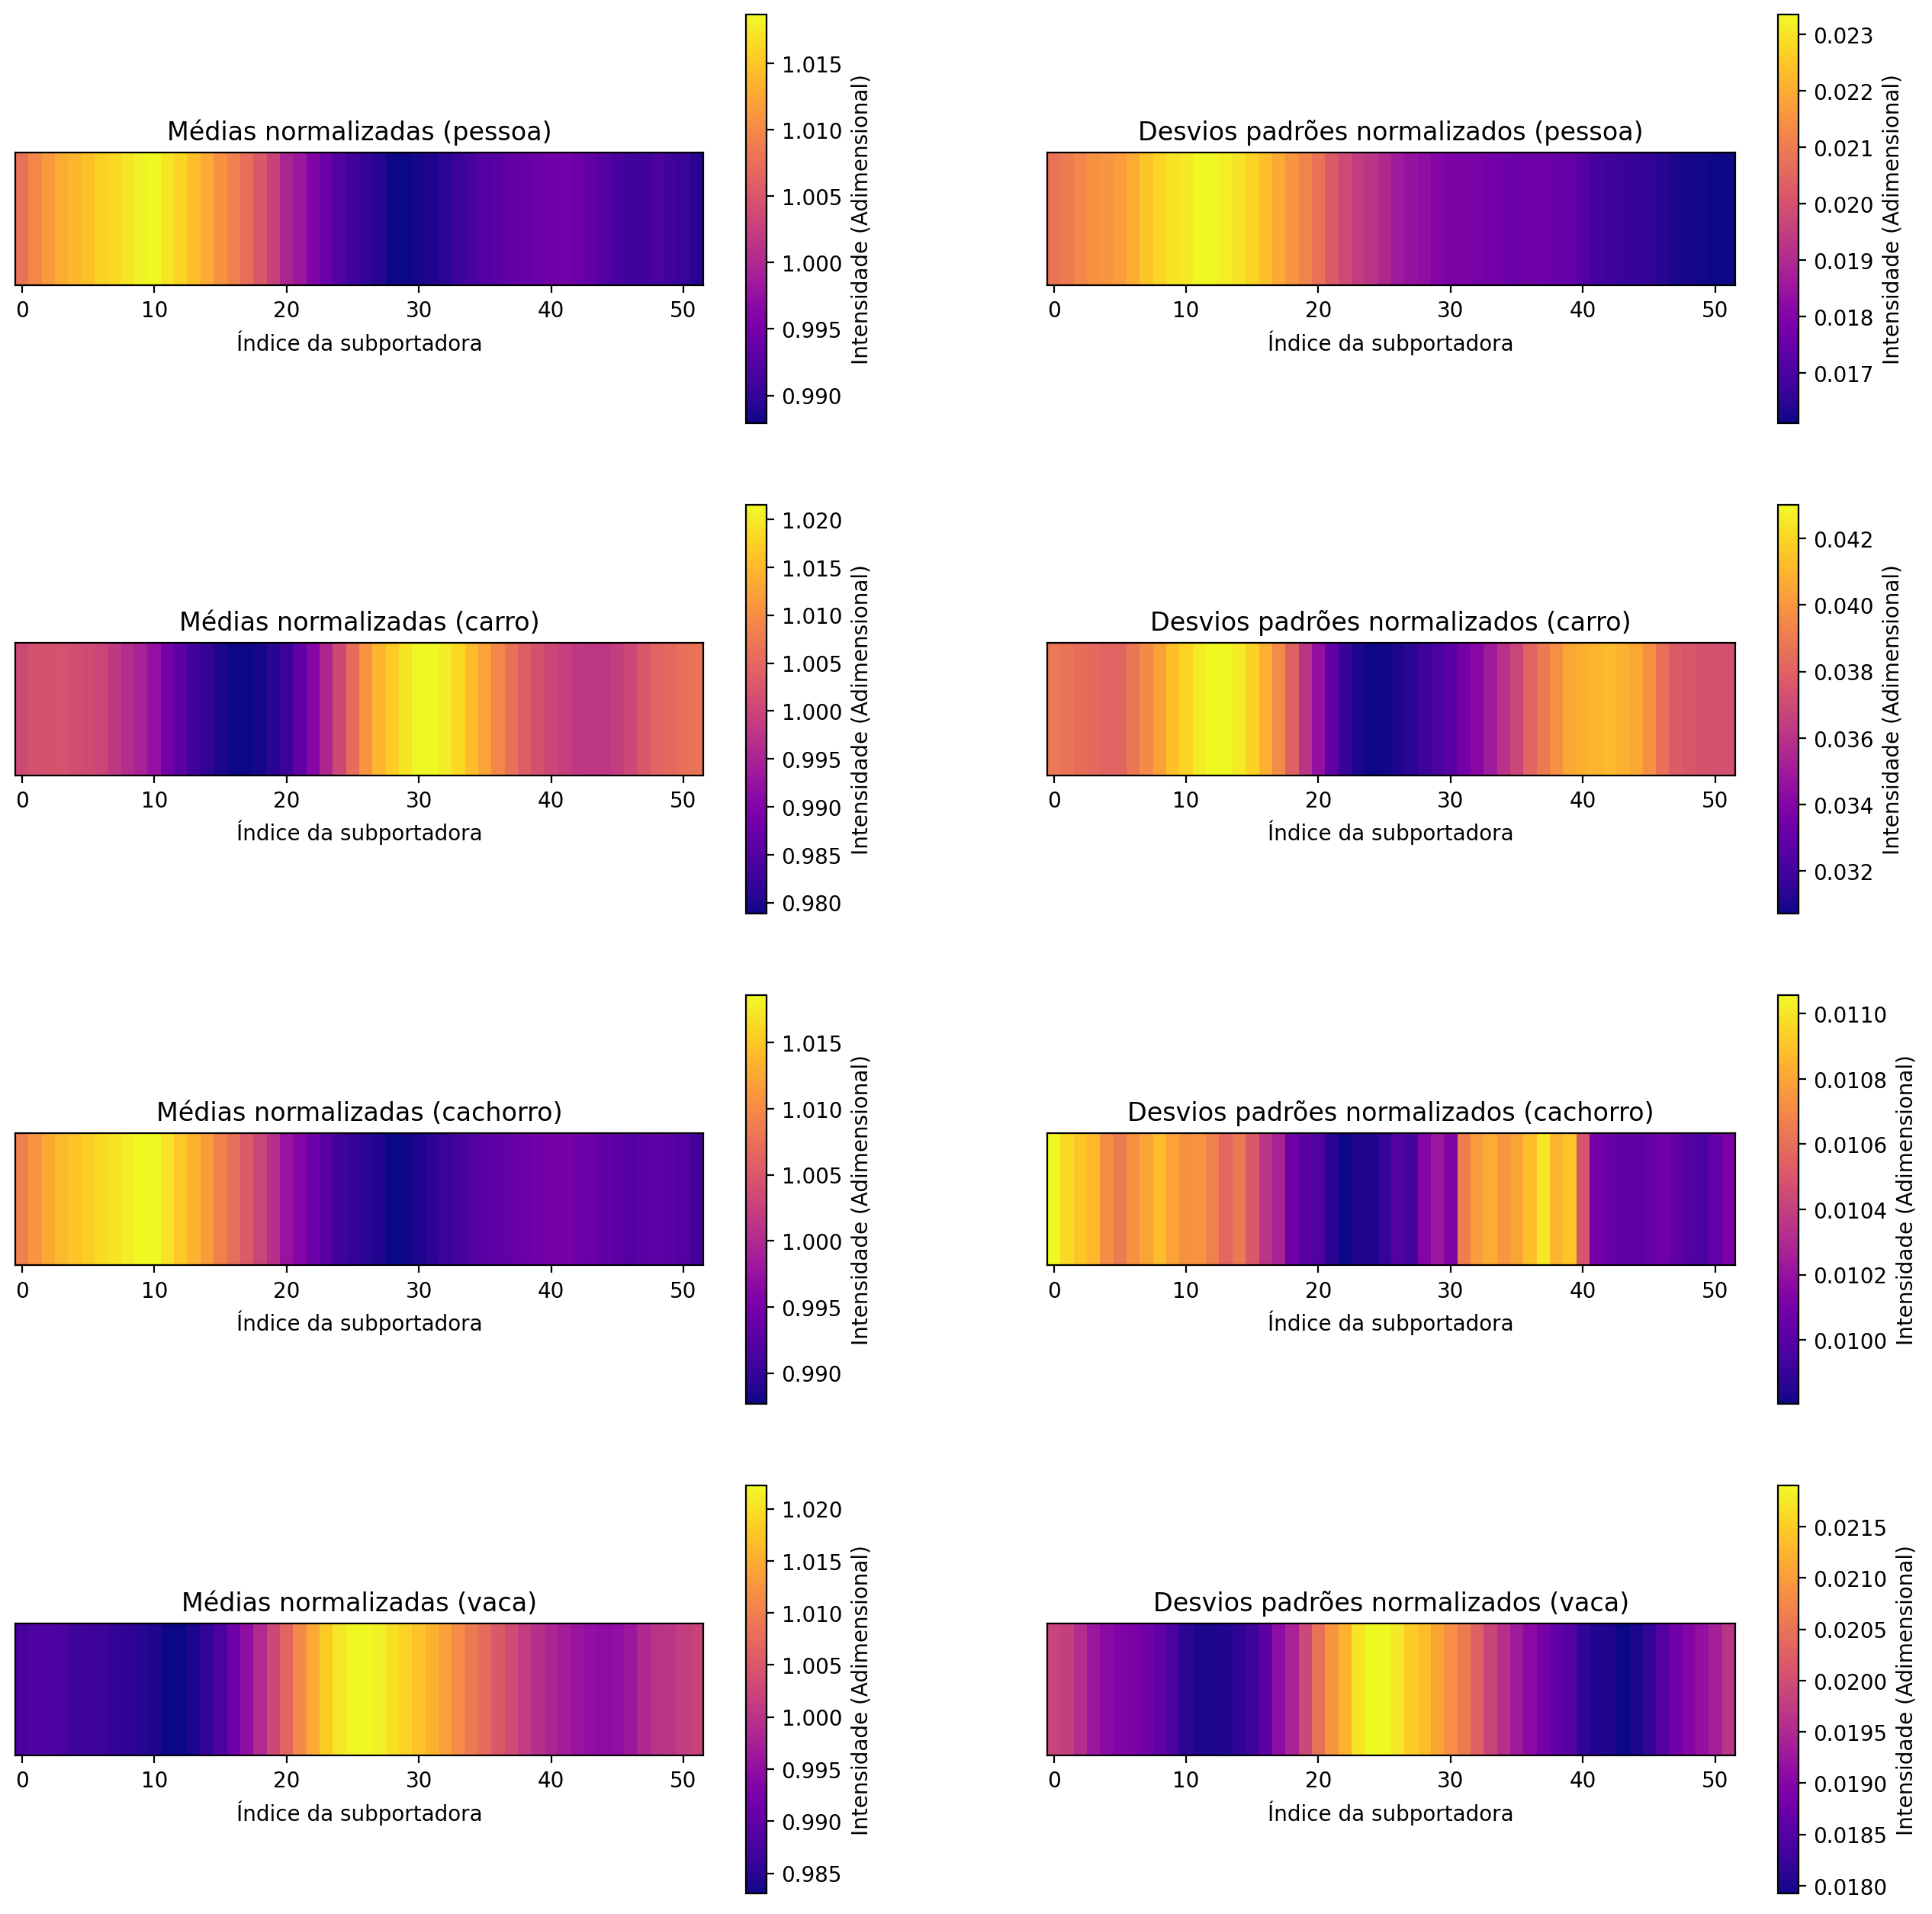

In [8]:
plot_some_features(n=10)

In [9]:
model, acc_score_16, _ = train_and_evaluate_model(
        model=KNeighborsClassifier(n_neighbors=31),
        x_train=train_features_16,
        y_train=train_labels_16,
        x_test=test_features_16,
        y_test=test_labels_16
)
importances = run_permutation_importance(model, test_features_16, test_labels_16, n_repeats=50, random_state=1)


(104, 2)
(52, 2)
(52, 2)


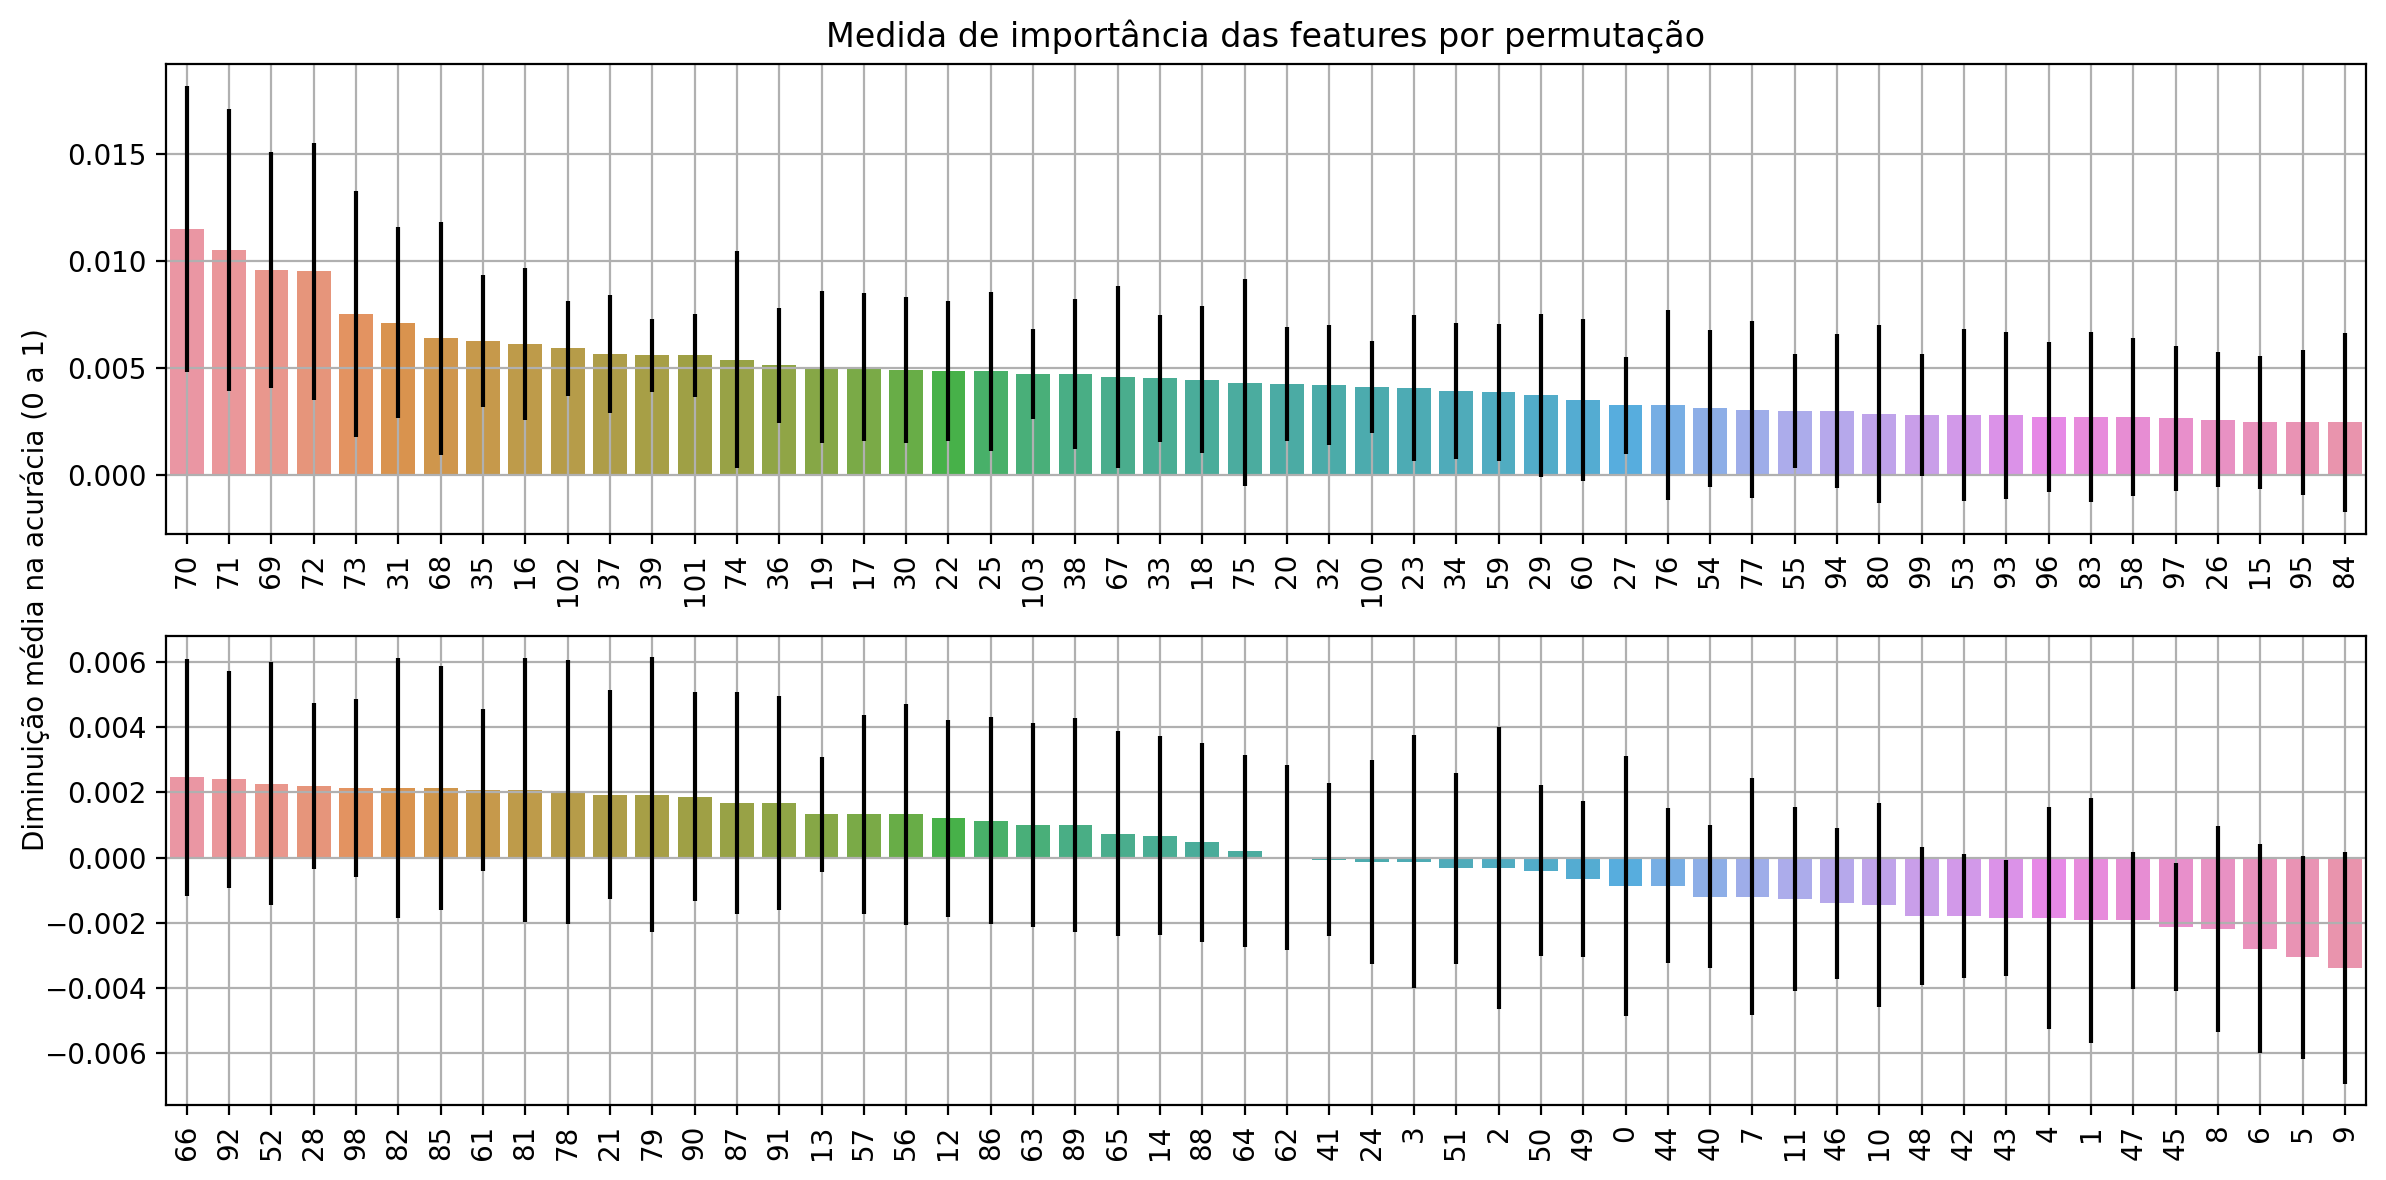

In [10]:
fig, ax = plt.subplots(2, 1, dpi=200, figsize=(12, 6))
print(importances.shape)
first_half_importances = importances.iloc[:52]
print(first_half_importances.shape)
second_half_importances = importances.iloc[52:]
print(second_half_importances.shape)
im1 = sns.barplot(ax=ax[0], x=first_half_importances.index, y="mean", data=first_half_importances, yerr=first_half_importances["std"], capsize=.2, order=first_half_importances.sort_values('mean', ascending=False).index)
im1.set_xticklabels(im1.get_xticklabels(), rotation=90)

im2 = sns.barplot(ax=ax[1], x=second_half_importances.index, y="mean", data=second_half_importances, yerr=second_half_importances["std"], capsize=.2, order=second_half_importances.sort_values('mean', ascending=False).index)
im2.set_xticklabels(im2.get_xticklabels(), rotation=90)

ax[0].set_title("Medida de importância das features por permutação")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
fig.text(0.01, 0.5, 'Diminuição média na acurácia (0 a 1)', va='center', rotation='vertical')
ax[0].grid()
ax[1].grid()
fig.tight_layout()
plt.show()

In [50]:
n_sigmas = 6
number_features = np.zeros((n_sigmas, n_sigmas))
accuracies = np.zeros((n_sigmas, n_sigmas))
features_for_sigmas = [[0 for _ in range(n_sigmas)] for _ in range(n_sigmas)]
for sig_positive in range(n_sigmas):
    for sig_negative in range(n_sigmas):
        positive_mask = (importances['mean'] >= 0) & (importances['mean'] - 0.5*sig_positive*importances['std'] > 0)
        negative_mask = (importances['mean'] < 0) & (importances['mean'] + 0.5*sig_negative*importances['std'] > 0)
        important_features = importances.index[positive_mask | negative_mask]
        _, acc_score, _ = train_and_evaluate_model(
            model=KNeighborsClassifier(n_neighbors=31),
            x_train=train_features_16[:, important_features],
            y_train=train_labels_16,
            x_test=test_features_16[:, important_features],
            y_test=test_labels_16
        )
        features_for_sigmas[sig_positive][sig_negative] = important_features.values
        number_features[sig_positive, sig_negative] = len(important_features)
        accuracies[sig_positive, sig_negative] = acc_score


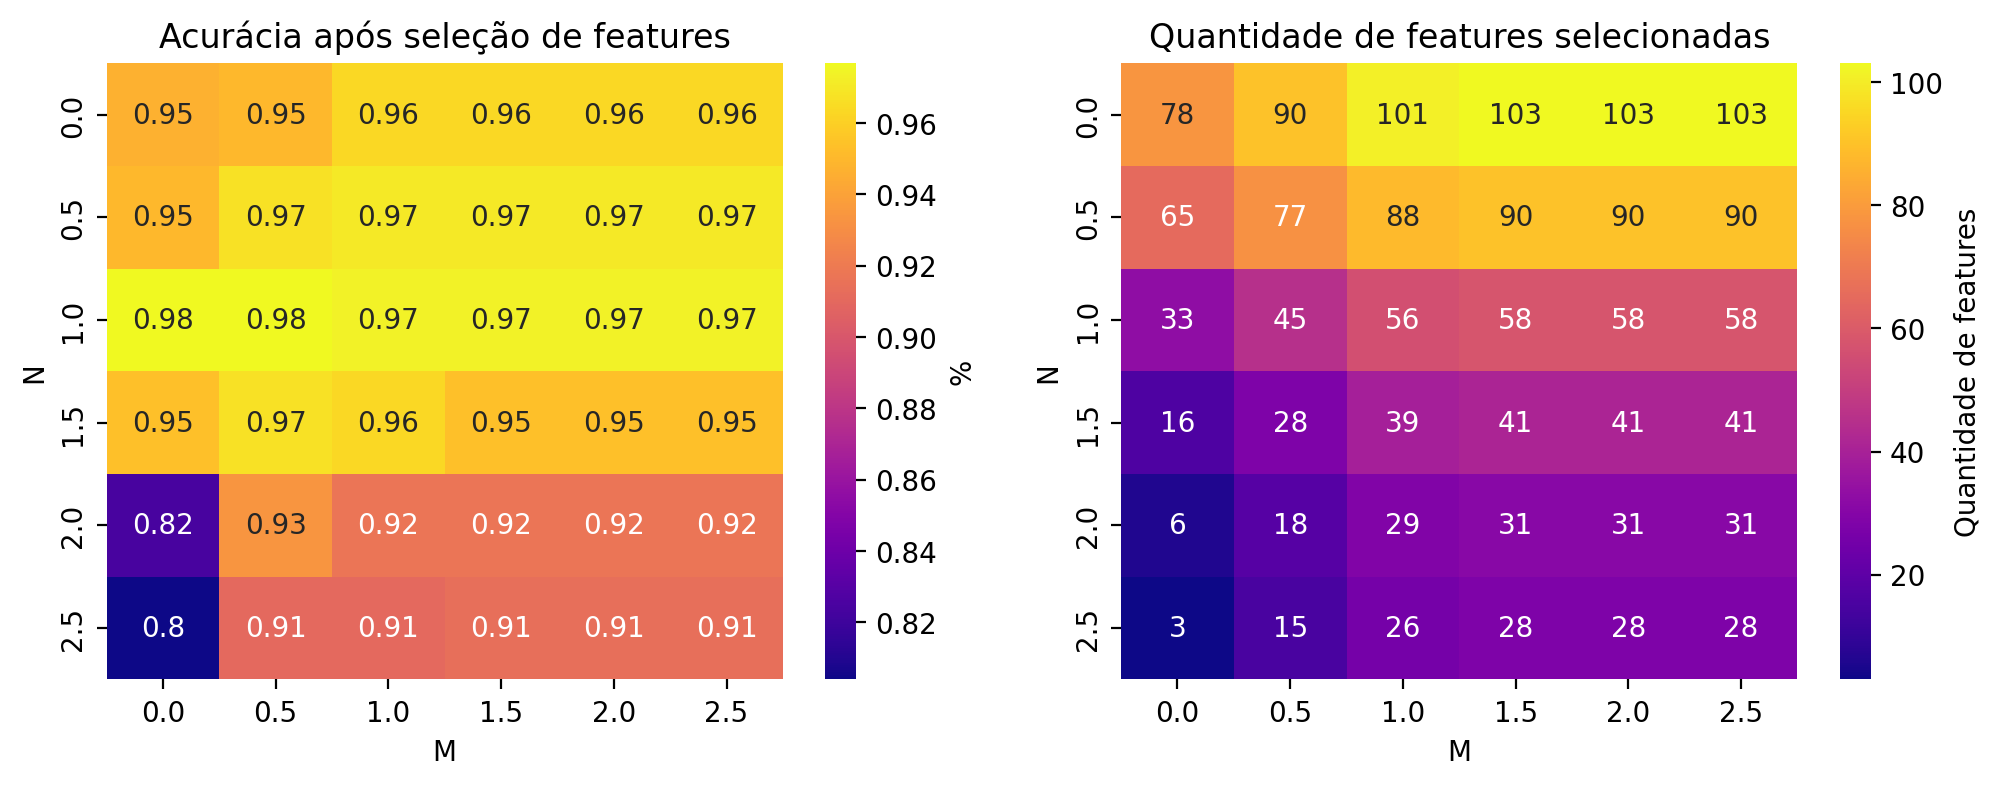

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=200)
sns.heatmap(accuracies, annot=True, ax=ax[0], cmap='plasma', cbar_kws={'label': '%'})
ax[0].set_title('Acurácia após seleção de features')
ax[0].set_ylabel('N')
ax[0].set_xlabel('M')
ax[0].set_xticklabels([0.5*i for i in range(n_sigmas)])
ax[0].set_yticklabels([0.5*i for i in range(n_sigmas)])

sns.heatmap(number_features, annot=True, ax=ax[1], cmap='plasma', cbar_kws={'label': 'Quantidade de features'}, fmt='g')
ax[1].set_title('Quantidade de features selecionadas')
ax[1].set_ylabel('N')
ax[1].set_xlabel('M')
ax[1].set_xticklabels([0.5*i for i in range(n_sigmas)])
ax[1].set_yticklabels([0.5*i for i in range(n_sigmas)])
plt.show()

In [54]:
#important_features = [ 70,  71,  69,  72,  73,  31,  68,  35,  16, 102,  37,  39, 101,
#             74,  36,  19,  17,  30,  22,  25, 103,  38,  67,  33,  18,  20,
#             32, 100,  23,  34,  59,  27,  55]
important_features=features_for_sigmas[3][0]

_, acc_score, _ = train_and_evaluate_model(
    model=KNeighborsClassifier(n_neighbors=31),
    x_train=train_features_16[:, important_features],
    y_train=train_labels_16,
    x_test=test_features_16[:, important_features],
    y_test=test_labels_16
)
print(acc_score)
important_features

0.9534883720930233


array([ 70,  71,  69,  72,  31,  35,  16, 102,  37,  39, 101,  36, 103,
        33,  20, 100])

In [35]:
features_for_sigmas

[[Int64Index([102, 39, 101], dtype='int64'),
  Int64Index([102, 39, 101, 41, 24, 3, 51, 2, 50, 49, 0, 44, 7, 11, 10], dtype='int64'),
  Int64Index([102,  39, 101,  41,  24,   3,  51,   2,  50,  49,   0,  44,  40,
                7,  11,  46,  10,  48,  42,   4,   1,  47,   8,   6,   5,   9],
             dtype='int64'),
  Int64Index([102,  39, 101,  41,  24,   3,  51,   2,  50,  49,   0,  44,  40,
                7,  11,  46,  10,  48,  42,  43,   4,   1,  47,  45,   8,   6,
                5,   9],
             dtype='int64'),
  Int64Index([102,  39, 101,  41,  24,   3,  51,   2,  50,  49,   0,  44,  40,
                7,  11,  46,  10,  48,  42,  43,   4,   1,  47,  45,   8,   6,
                5,   9],
             dtype='int64'),
  Int64Index([102,  39, 101,  41,  24,   3,  51,   2,  50,  49,   0,  44,  40,
                7,  11,  46,  10,  48,  42,  43,   4,   1,  47,  45,   8,   6,
                5,   9],
             dtype='int64')],
 [Int64Index([102, 39, 101], dtype='int64

In [ ]:
train_features_16[:, important_features]

array([[0.01494 , 0.01394 , 0.01319 , ..., 0.01261 , 0.01293 , 0.01312 ],
       [0.0171  , 0.01639 , 0.01595 , ..., 0.01588 , 0.0161  , 0.01656 ],
       [0.02039 , 0.01907 , 0.01787 , ..., 0.015076, 0.01508 , 0.0151  ],
       ...,
       [0.03004 , 0.0297  , 0.02953 , ..., 0.03093 , 0.0319  , 0.03333 ],
       [0.02892 , 0.02895 , 0.0283  , ..., 0.02881 , 0.02911 , 0.02924 ],
       [0.013794, 0.01271 , 0.01213 , ..., 0.01001 , 0.00962 , 0.00931 ]],
      dtype=float16)

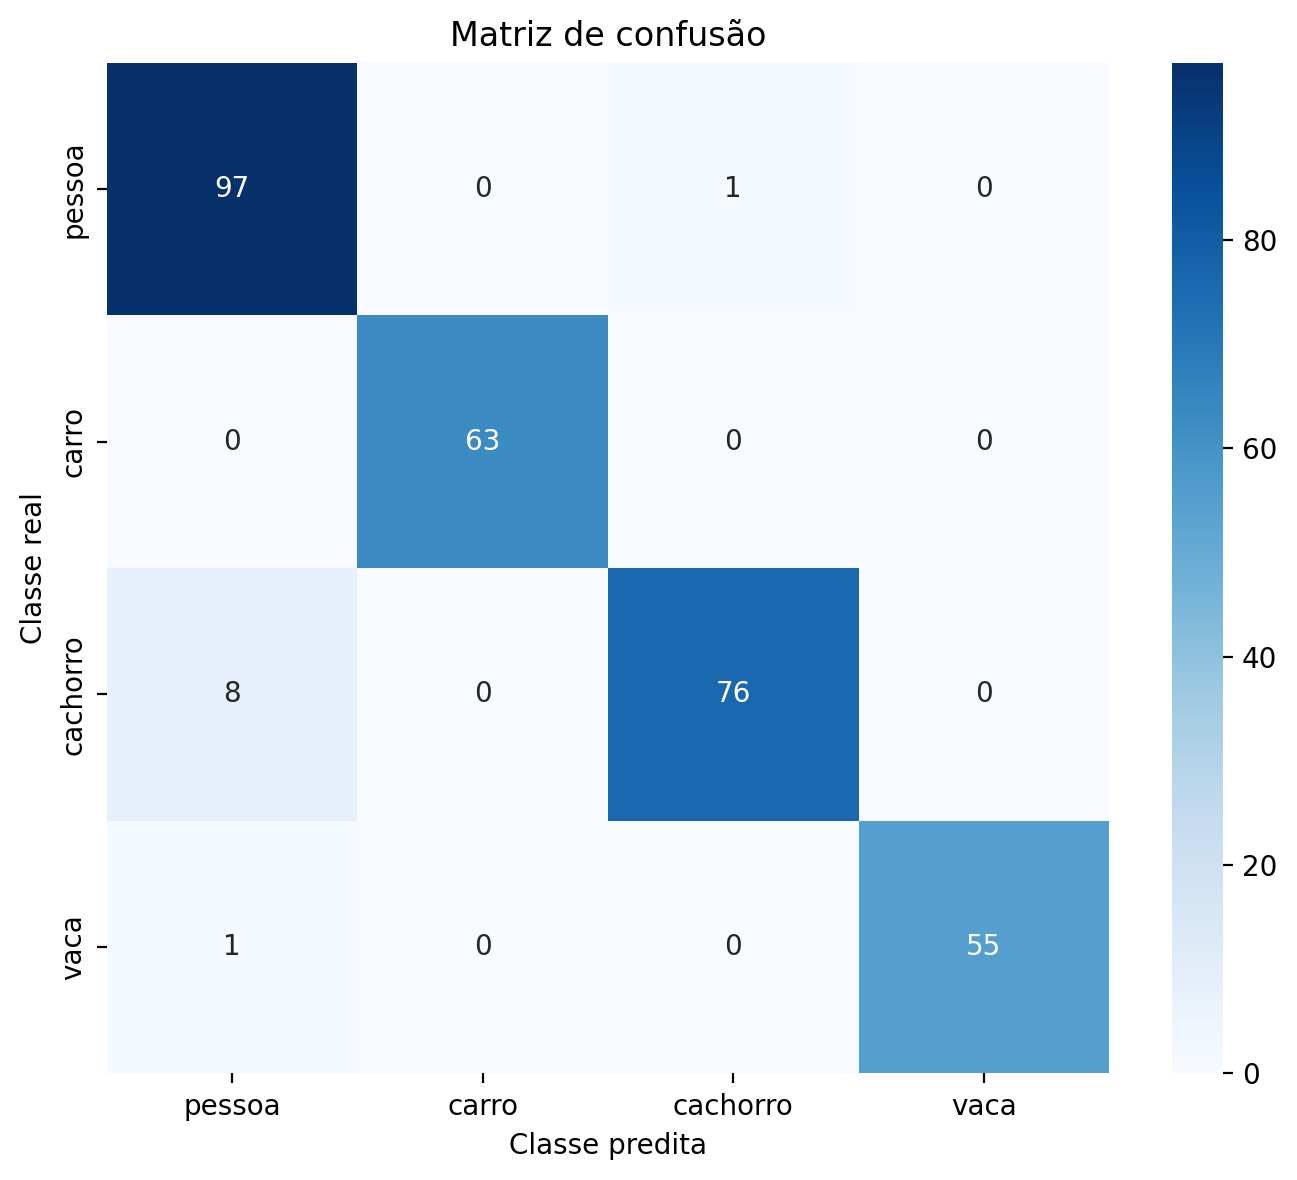

In [13]:

_, acc_score, conf_matrix = train_and_evaluate_model(
    model=KNeighborsClassifier(n_neighbors=31),
    x_train=train_features_16,
    y_train=train_labels_16,
    x_test=test_features_16,
    y_test=test_labels_16
)
plt.figure(figsize=(7, 6), dpi=200)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(label_map_pt.values()), yticklabels=list(label_map_pt.values()))
plt.xlabel('Classe predita')
plt.ylabel('Classe real')
plt.title('Matriz de confusão')
plt.tight_layout()
plt.show()


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    "n_estimators": [10, 50, 100, 150, 200],
    "max_depth": [3, 5, 10, None],
    "max_features": [1, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

param_grid_lr = {
    "C": [0.1, 1, 10, 100],
    "penalty": ["l2"],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

param_grid_svm = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}

rf = RandomForestClassifier()
lr = LogisticRegression()
svm = SVC()


random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid_rf, n_iter=10, cv=5, random_state=1)
random_search_lr = RandomizedSearchCV(lr, param_distributions=param_grid_lr, n_iter=10, cv=5, random_state=1)
random_search_svm = RandomizedSearchCV(svm, param_distributions=param_grid_svm, n_iter=10, cv=5, random_state=1)

random_search_rf.fit(train_features_16, train_labels_16)
random_search_lr.fit(train_features_16, train_labels_16)
random_search_svm.fit(train_features_16, train_labels_16)

print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best score for Random Forest:", random_search_rf.best_score_)

print("Best parameters for Logistic Regression:", random_search_lr.best_params_)
print("Best score for Logistic Regression:", random_search_lr.best_score_)

print("Best parameters for SVM:", random_search_svm.best_params_)
print("Best score for SVM:", random_search_svm.best_score_)

rf_best = random_search_rf.best_estimator_
lr_best = random_search_lr.best_estimator_
svm_best = random_search_svm.best_estimator_

print("Test set score for Random Forest:", rf_best.score(test_features_16, test_labels_16))
print("Test set score for Logistic Regression:", lr_best.score(test_features_16, test_labels_16))
print("Test set score for SVM:", svm_best.score(test_features_16, test_labels_16))


/home/paulo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paulo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paulo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paulo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paulo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/paulo/anaconda3/lib/python3.11/site-packages/sklearn/linear_mode

Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': None, 'criterion': 'entropy'}
Best score for Random Forest: 0.9918633565692389
Best parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100}
Best score for Logistic Regression: 0.8923932982756512
Best parameters for SVM: {'kernel': 'poly', 'gamma': 1, 'C': 10}
Best score for SVM: 0.9737801149565856
Test set score for Random Forest: 0.9102990033222591
Test set score for Logistic Regression: 0.8538205980066446
Test set score for SVM: 0.8604651162790697
